# (Split 7/3)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error

In [2]:
# 1. Đọc file csv và gắng index với giá Price
df = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\dataset\\ELC.csv')
df1 = df.reset_index()['close']

In [3]:
# 2. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [4]:
# 3. Chia train/test: 70/30
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 4. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X, y = create_dataset(df1, time_step)

X_train = X[:train_size-time_step]
X_test = X[train_size-time_step:]

y_train = y[:train_size-time_step]
y_test = y[train_size-time_step:]

In [6]:
# 5. Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [7]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
13/13 [==============================] - 10s 280ms/step - loss: 0.0187 - val_loss: 0.0435
Epoch 2/100
13/13 [==============================] - 2s 154ms/step - loss: 0.0037 - val_loss: 0.0079
Epoch 3/100
13/13 [==============================] - 2s 150ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 4/100
13/13 [==============================] - 2s 148ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 5/100
13/13 [==============================] - 2s 149ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 6/100
13/13 [==============================] - 2s 150ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 7/100
13/13 [==============================] - 2s 150ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 8/100
13/13 [==============================] - 2s 151ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 9/100
13/13 [==============================] - 2s 150ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 10/100
13/13 [==============================] - 2s 149ms/step - loss: 0.0013 - val_l

In [9]:
# 8. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

13/13 [==============================] - 0s 31ms/step


In [10]:
# 9. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

# Chuẩn hóa ngược lại y_train và y_test
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
# 10. Đánh giá độ chính xác thuật toán bằng RMSE, MAE, MAPE, MSLE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
test_msle = np.mean((np.log1p(y_pred) - np.log1p(y_test))**2)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)
print('Testing MSLE:', test_msle)

Testing RMSE: 962.4337387004083
Testing MAE: 675.774125038413
Testing MAPE: 4.324583835128728
Testing MSLE: 0.0033183052521706257


In [12]:
# 11. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future_days(model, data, n_steps, days):
    temp_input = list(data[-n_steps:].reshape(-1))
    lst_output = []

    for i in range(days):
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])

    return scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

n_days = [30, 60, 90]
predictions = {days: predict_future_days(model, test_data, time_step, days) for days in n_days}


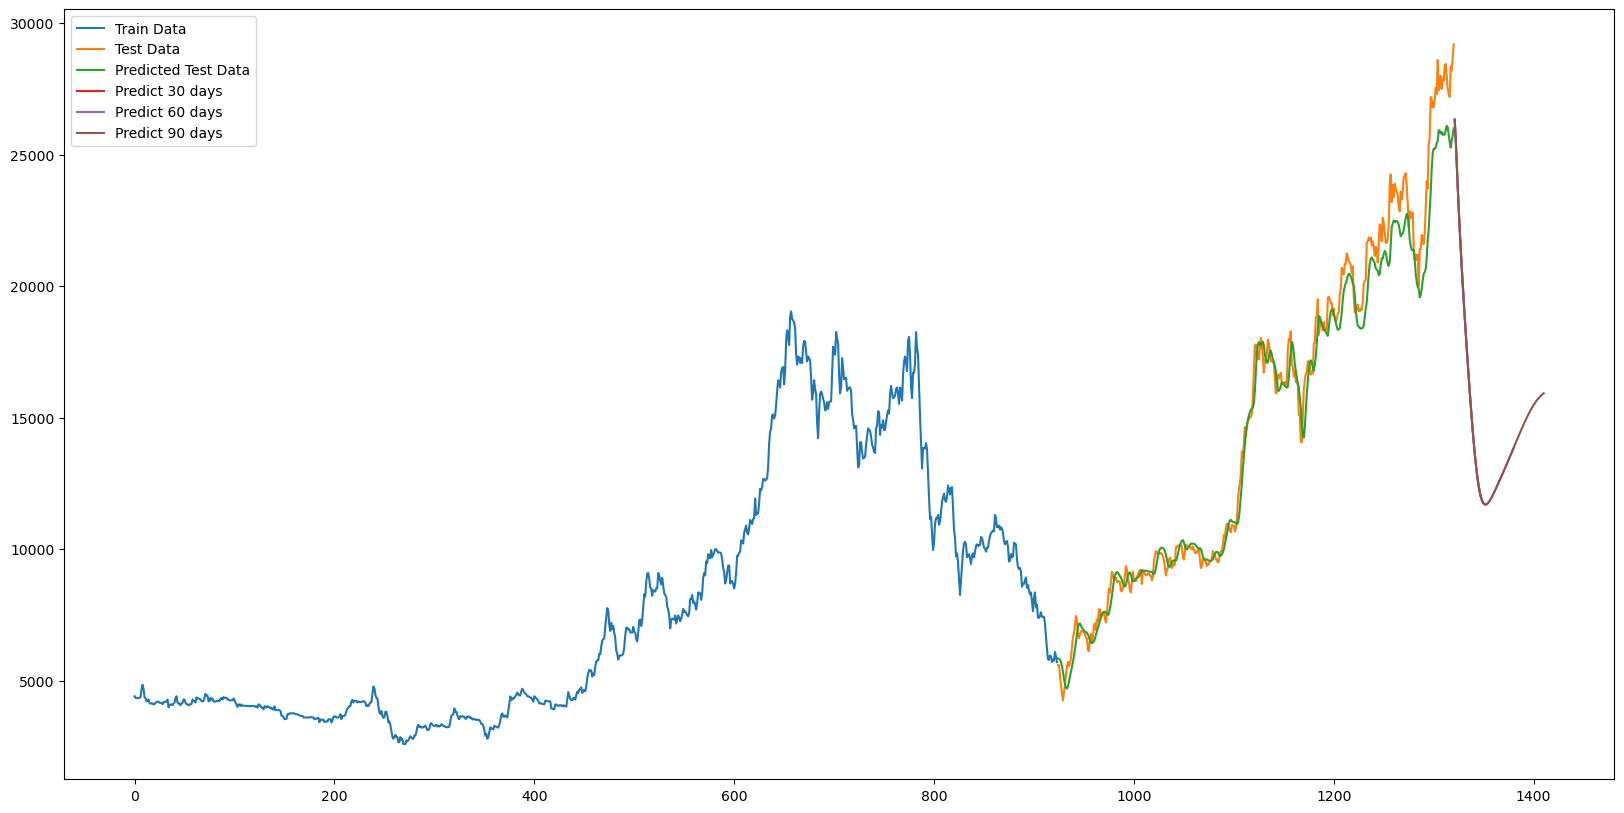

In [13]:
# 12. Vẽ hình tổng quan
plt.figure(figsize=(20, 10))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train Data')

test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test Data')
plt.plot(test_data_index, y_pred, label='Predicted Test Data')

for days, pred in predictions.items():
    pred_index = pd.RangeIndex(start=len(df1), stop=len(df1) + days, step=1)
    plt.plot(pred_index, pred, label=f'Predict {days} days')

plt.legend()
plt.show()

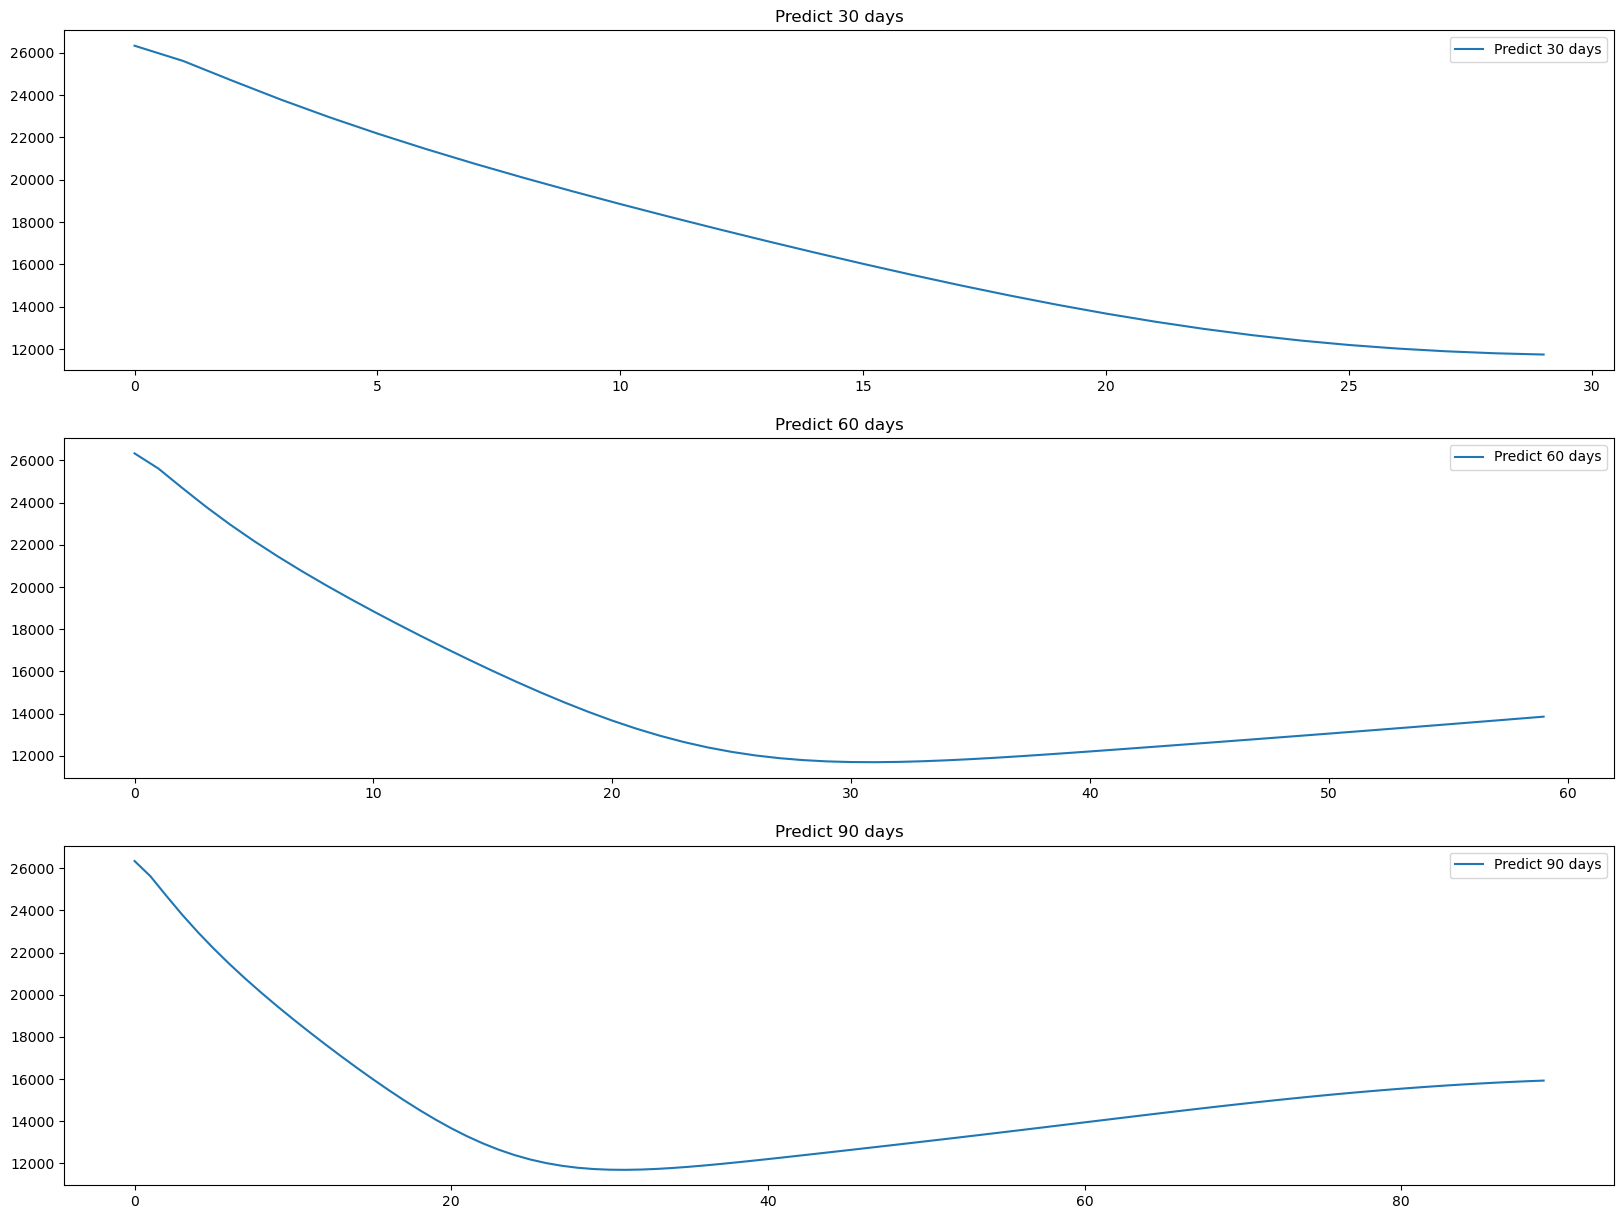

In [14]:
# 13. Vẽ hình riêng biệt cho 30, 60, 90 ngày
fig, axs = plt.subplots(3, 1, figsize=(20, 15))

for i, days in enumerate(n_days):
    pred = predictions[days]
    pred_index = pd.RangeIndex(start=0, stop=days, step=1)
    axs[i].plot(pred_index, pred)
    axs[i].set_title(f'Predict {days} days')
    axs[i].legend([f'Predict {days} days'])

plt.show()

# (Split 8/2)

Epoch 1/100
15/15 [==============================] - 11s 249ms/step - loss: 0.0252 - val_loss: 0.0583
Epoch 2/100
15/15 [==============================] - 2s 150ms/step - loss: 0.0036 - val_loss: 0.0101
Epoch 3/100
15/15 [==============================] - 2s 154ms/step - loss: 0.0017 - val_loss: 0.0063
Epoch 4/100
15/15 [==============================] - 2s 157ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 5/100
15/15 [==============================] - 2s 157ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 6/100
15/15 [==============================] - 2s 163ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 7/100
15/15 [==============================] - 3s 170ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 8/100
15/15 [==============================] - 2s 149ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 9/100
15/15 [==============================] - 2s 151ms/step - loss: 0.0010 - val_loss: 0.0087
Epoch 10/100
15/15 [==============================] - 2s 149ms/step - loss: 9.2961e-04 - v

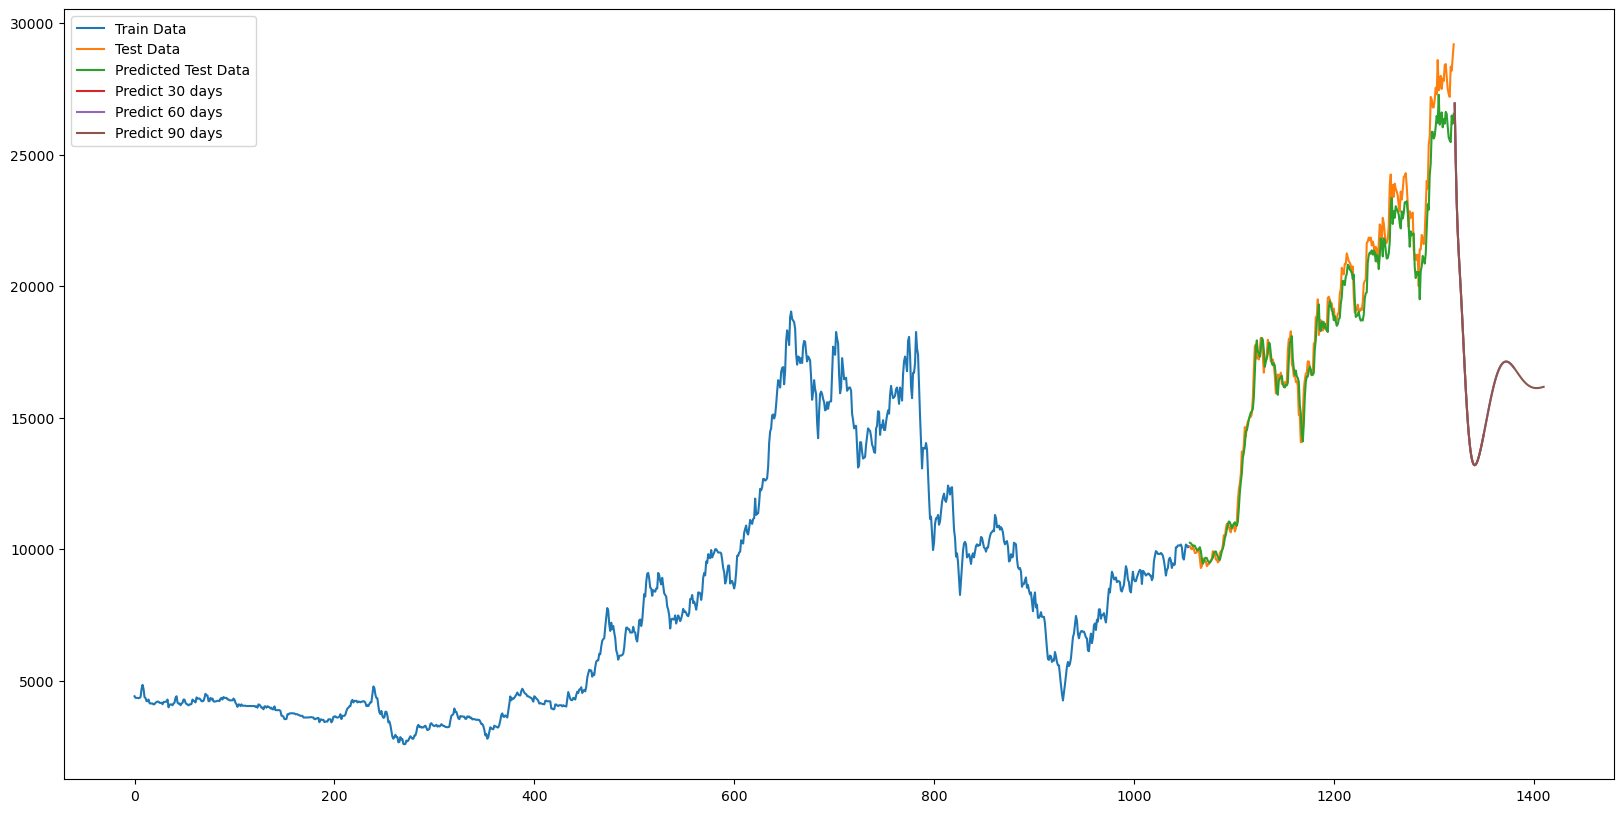

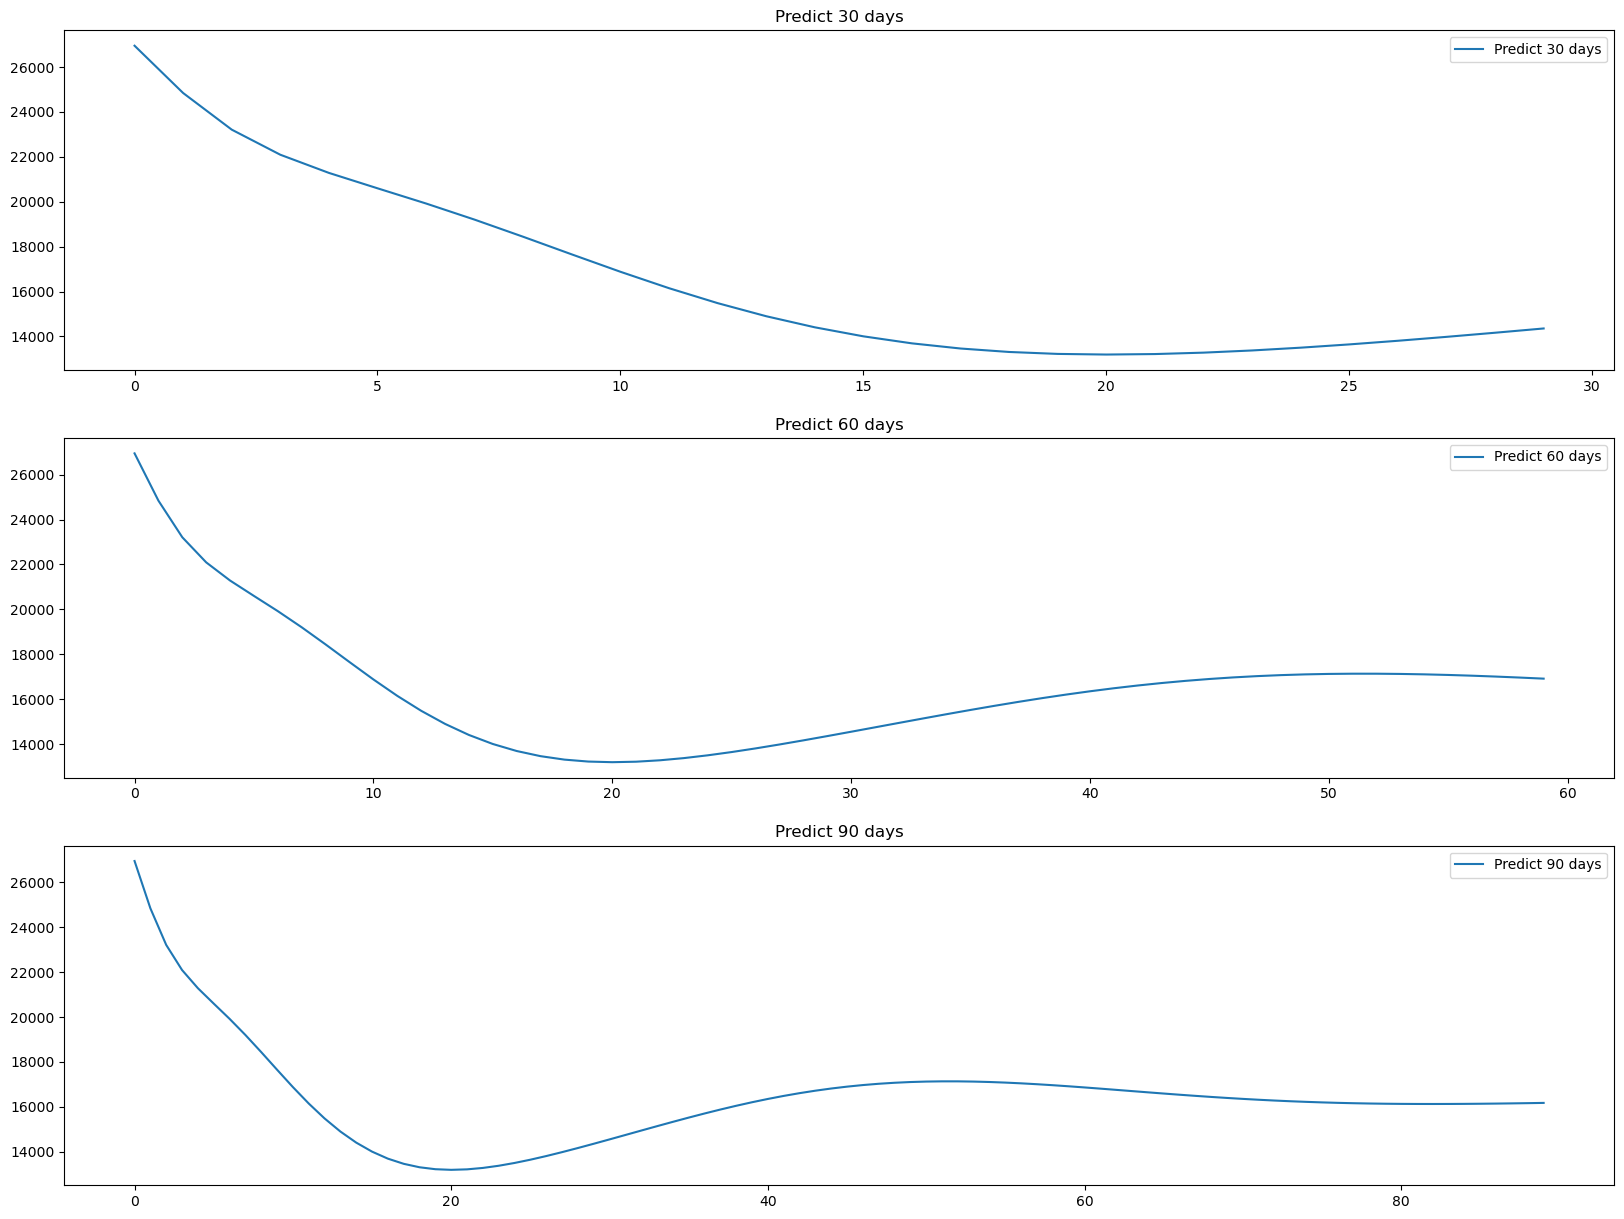

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error

# 1. Đọc file csv và gắng index với giá Price
df = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\dataset\\ELC.csv')
df1 = df.reset_index()['close']
# 2. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))
# 3. Chia train/test:
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]


# 4. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


time_step = 100
X, y = create_dataset(df1, time_step)

X_train = X[:train_size - time_step]
X_test = X[train_size - time_step:]

y_train = y[:train_size - time_step]
y_test = y[train_size - time_step:]
# 5. Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# 8. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

# 9. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

# Chuẩn hóa ngược lại y_train và y_test
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# 10. Đánh giá độ chính xác thuật toán bằng RMSE, MAE, MAPE, MSLE
test_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
test_msle = np.mean((np.log1p(y_pred) - np.log1p(y_test)) ** 2)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)
print('Testing MSLE:', test_msle)


# 11. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future_days(model, data, n_steps, days):
    temp_input = list(data[-n_steps:].reshape(-1))
    lst_output = []

    for i in range(days):
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])

    return scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))


n_days = [30, 60, 90]
predictions = {days: predict_future_days(model, test_data, time_step, days) for days in n_days}

# 12. Vẽ hình tổng quan
plt.figure(figsize=(20, 10))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train Data')

test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test Data')
plt.plot(test_data_index, y_pred, label='Predicted Test Data')

for days, pred in predictions.items():
    pred_index = pd.RangeIndex(start=len(df1), stop=len(df1) + days, step=1)
    plt.plot(pred_index, pred, label=f'Predict {days} days')

plt.legend()
plt.show()

# 13. Vẽ hình riêng biệt cho 30, 60, 90 ngày
fig, axs = plt.subplots(3, 1, figsize=(20, 15))

for i, days in enumerate(n_days):
    pred = predictions[days]
    pred_index = pd.RangeIndex(start=0, stop=days, step=1)
    axs[i].plot(pred_index, pred)
    axs[i].set_title(f'Predict {days} days')
    axs[i].legend([f'Predict {days} days'])

plt.show()

# (Split 9/1)

Epoch 1/100
17/17 [==============================] - 10s 228ms/step - loss: 0.0232 - val_loss: 0.0628
Epoch 2/100
17/17 [==============================] - 2s 124ms/step - loss: 0.0033 - val_loss: 0.0112
Epoch 3/100
17/17 [==============================] - 2s 125ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 4/100
17/17 [==============================] - 2s 138ms/step - loss: 0.0018 - val_loss: 0.0057
Epoch 5/100
17/17 [==============================] - 2s 127ms/step - loss: 0.0016 - val_loss: 0.0072
Epoch 6/100
17/17 [==============================] - 2s 134ms/step - loss: 0.0014 - val_loss: 0.0101
Epoch 7/100
17/17 [==============================] - 2s 124ms/step - loss: 0.0013 - val_loss: 0.0058
Epoch 8/100
17/17 [==============================] - 2s 125ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 9/100
17/17 [==============================] - 2s 148ms/step - loss: 0.0011 - val_loss: 0.0081
Epoch 10/100
17/17 [==============================] - 2s 144ms/step - loss: 0.0010 - val_l

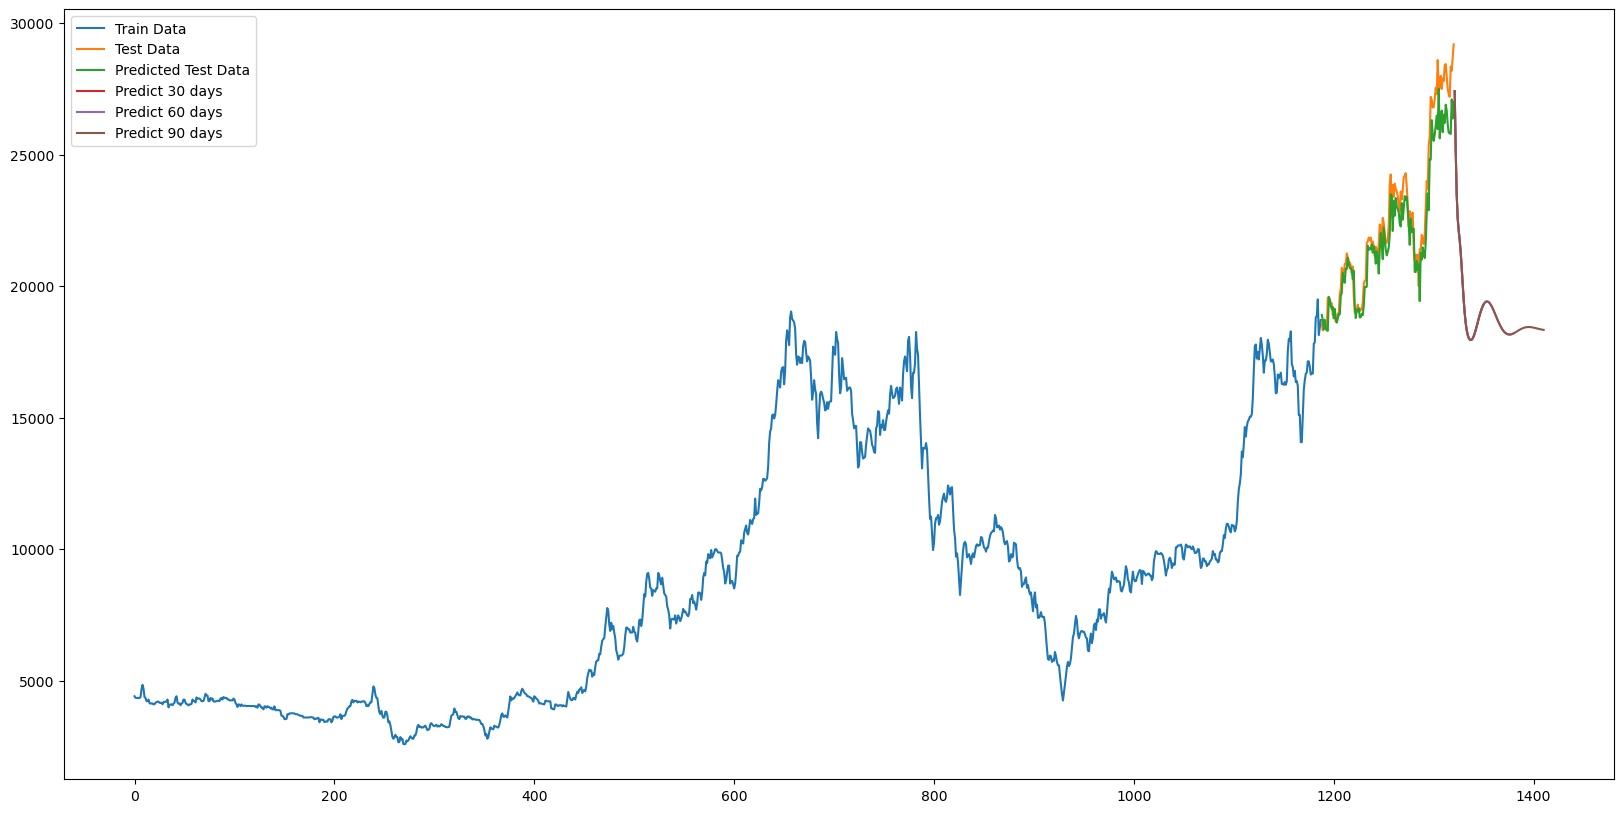

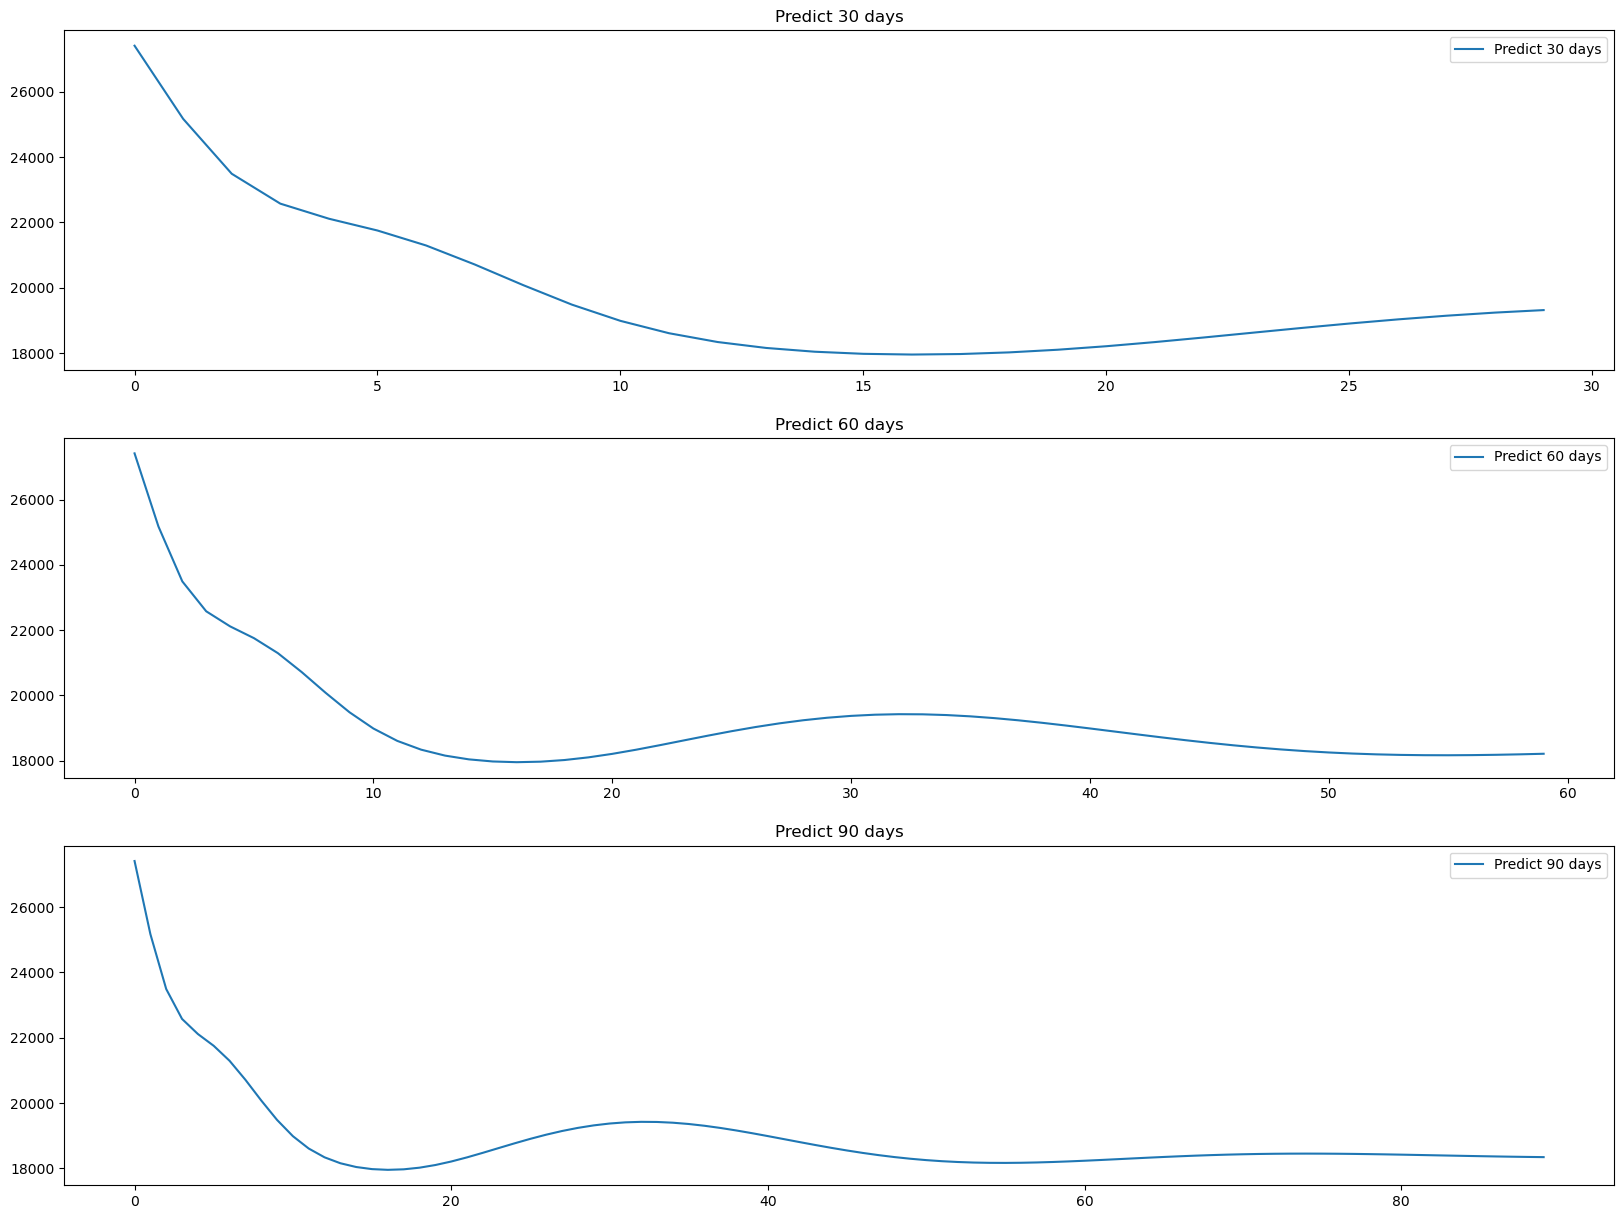

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error

# 1. Đọc file csv và gắng index với giá Price
df = pd.read_csv('D:\\Workspace\\23-24_HK2\\IS403-PTDLKD\\dataset\\ELC.csv')
df1 = df.reset_index()['close']
# 2. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))
# 3. Chia train/test:
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]


# 4. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


time_step = 100
X, y = create_dataset(df1, time_step)

X_train = X[:train_size - time_step]
X_test = X[train_size - time_step:]

y_train = y[:train_size - time_step]
y_test = y[train_size - time_step:]
# 5. Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# 8. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

# 9. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

# Chuẩn hóa ngược lại y_train và y_test
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

from sklearn.metrics import mean_absolute_error, mean_squared_log_error

# 10. Đánh giá độ chính xác thuật toán bằng RMSE, MAE, MAPE, MSLE
test_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
test_mae = mean_absolute_error(y_test, y_pred)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
test_msle = np.mean((np.log1p(y_pred) - np.log1p(y_test)) ** 2)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Testing MAPE:', test_mape)
print('Testing MSLE:', test_msle)


# 11. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future_days(model, data, n_steps, days):
    temp_input = list(data[-n_steps:].reshape(-1))
    lst_output = []

    for i in range(days):
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape(1, n_steps, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])

    return scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))


n_days = [30, 60, 90]
predictions = {days: predict_future_days(model, test_data, time_step, days) for days in n_days}

# 12. Vẽ hình tổng quan
plt.figure(figsize=(20, 10))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train Data')

test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test Data')
plt.plot(test_data_index, y_pred, label='Predicted Test Data')

for days, pred in predictions.items():
    pred_index = pd.RangeIndex(start=len(df1), stop=len(df1) + days, step=1)
    plt.plot(pred_index, pred, label=f'Predict {days} days')

plt.legend()
plt.show()

# 13. Vẽ hình riêng biệt cho 30, 60, 90 ngày
fig, axs = plt.subplots(3, 1, figsize=(20, 15))

for i, days in enumerate(n_days):
    pred = predictions[days]
    pred_index = pd.RangeIndex(start=0, stop=days, step=1)
    axs[i].plot(pred_index, pred)
    axs[i].set_title(f'Predict {days} days')
    axs[i].legend([f'Predict {days} days'])

plt.show()